<a href="https://colab.research.google.com/github/cc-ats/mlp_class/blob/cw_cl/Mueller_Brown_GPR_CL_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lesson 2: Mueller-Brown Poteintial Tutorial - Modified for use with Gaussian Process Regression (GPR)**

In [1]:
#@title ***(2.1) Defining the Mueller-Brown Potential Energy Surface***

#@markdown For the definition of Mueller-Brown potential, see 
#@markdown https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb. \
#@markdown $v(x,y) = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right] $

#@markdown In this tutorial, we will learn how to use a gaussian process 
#@markdown regression model to predict the energy of points on the Mueller-Brown
#@markdown potential energy surface.

#@markdown We will start by defining the Mueller-Brown potential energy
#@markdown surface. Displayed below are the max/min values of the surface and 
#@markdown the size of the training set. \
#@markdown **Generate Traning Data**
# capture hides the output
%%capture 
!pip3 install ipympl
%matplotlib ipympl
from math import exp, pow, tanh
import numpy as np
import matplotlib.pyplot as plt

def mueller_brown_potential(x, y):
  A = [-200, -100, -170, 15]
  a = [-1, -1, -6.5, 0.7]
  b = [0, 0, 11, 0.6]
  c = [-10, -10, -6.5, 0.7]
  x0 = [1, 0, -0.5, -1.0]
  y0 = [0, 0.5, 1.5, 1]
  value = 0
  for k in range(0, 4):
    value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0))
  return value

#Generating training data
#main function
xx = np.arange(-1.8, 1.4, 0.1)
yy = np.arange(-0.4, 2.4, 0.1)
X, Y = np.meshgrid(xx, yy)
xy, xy_truncated = [],[]
z, z_truncated = [], []
for y in yy:
  for x in xx:
    v = mueller_brown_potential(x,y)
    z.append(v)
    xy.append([x,y])
    if v < 10:  #keep only low-energy points for ML training
      xy_truncated.append([x, y])
      z_truncated.append(v)
Z = np.reshape(z,(len(yy),-1))
print("Zmin:", np.amin(Z), "Zmax:", np.amax(Z))
print("Size of (future) training set:", len(z_truncated))

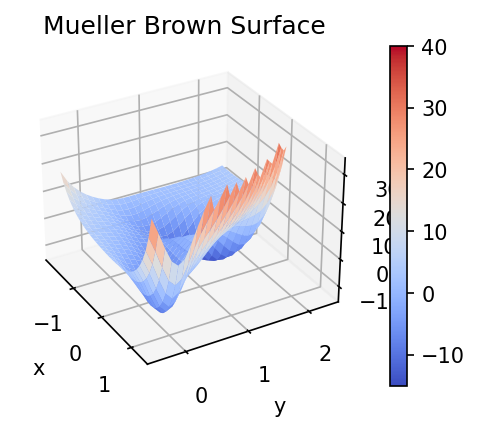

In [2]:
#@title ***(2.2) 3-D Projection Surface***

#@markdown We will now create a 3-D surface plot of our training data. 
#@markdown To make the plot more readable, we will copy over the points that 
#@markdown are extremely high energy with nan (not a number). This will keep 
#@markdown our Z array the same shape and help us ignore the high energy region 
#@markdown that we are not interested in. 

%matplotlib inline 
# keep widget or use inline?
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import output
output.enable_custom_widget_manager()
import copy

fig = plt.figure(figsize=(6,3), dpi=150)
ax = fig.add_subplot(projection='3d')

# Made copy of Z just to clean up the plot.
clean_Z = copy.copy(Z)
clean_Z[clean_Z>35] = np.nan
#print(np.amax(clean_Z), np.amin(clean_Z))
surf=ax.plot_surface(X, Y, clean_Z, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none', vmin=-15, vmax=40)

ax.view_init(30,-30)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title('Mueller Brown Surface')
plt.colorbar(surf)
plt.show()

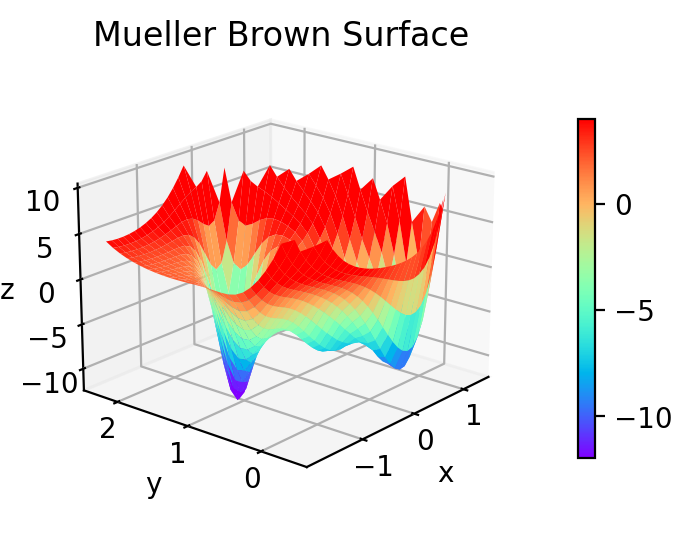

In [3]:
#@title ***(2.2) 3-D Projection Surface***

#@markdown We will now create a 3-D surface plot of our training data. 
#@markdown To make the plot more readable, we will copy over the points that 
#@markdown are extremely high energy with nan (not a number). This will keep 
#@markdown our Z array the same shape and help us ignore the high energy region 
#@markdown that we are not interested in. 
%matplotlib inline
import matplotlib.pyplot as plt  #must import again
from mpl_toolkits.mplot3d import Axes3D
import copy

fig = plt.figure(figsize=(9,3), dpi=200)
ax = fig.add_subplot(projection='3d')

# Made copy of Z just to clean up the plot.
clean_Z = copy.copy(Z)
clean_Z[clean_Z>10] = np.nan

surf=ax.plot_surface(X, Y, clean_Z, rstride=1, cstride=1,
                cmap=plt.cm.rainbow, edgecolor='none', vmin=-12, vmax=4)

ax.tick_params(axis='both', pad=-4,labelsize=10)
ax.tick_params(axis='z', pad=-1,labelsize=10)
ax.set_xlabel("x", labelpad=-5)
ax.set_ylabel("y",labelpad=-5)
ax.set_zlabel("z",labelpad=-6)
# ax.view_init(30,-30)
ax.view_init(20,220)
ax.set_zlim3d(-12, 10) 

ax.set_title('Mueller Brown Surface')
plt.colorbar(surf, shrink=0.75)
plt.show()




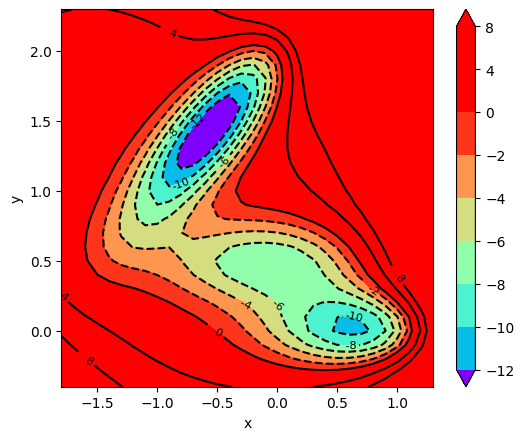

In [4]:
#@title ***(2.3) Contour Surface***
#@markdown Now we will create a contour surface plot of our training data. 

fig = plt.figure(figsize=(6,5), dpi=100) 
levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8] 
ct = plt.contour(X, Y, Z, levels, colors='k') 
plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8) 
ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.colorbar() 
plt.show()

In [5]:
#@title ***(2.4) Loading PyTorch, GpyTorch***
#@markdown Now we will install GpyTorch
!pip install gpytorch

import numpy as np
import torch
import gpytorch
from torch import Tensor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#@title ***(2.5) The GPR Class***
#@markdown Let us define the variables in our function as a vector of input features $\textbf{x}=[x,y]$ 

#@markdown A set of $n$ configurations can be assembled into a training set 
#@markdown $\textbf{X}=[\textbf{x}_1, ...,\textbf{x}_n]$ with a set of 
#@markdown observations $\textbf{y}=[y_1,...,y_n]$. For noisy samples, we can 
#@markdown assume that an observations is seperate from the underlying function 
#@markdown according to $y=f(\textbf{x})+\mathit{ε}$, where the noise, 
#@markdown $\mathit{ε}$, follows a gaussian distribution $\mathit{ε}\sim\mathcal{N}(0,σ^2_n)$, 
#@markdown where $\sigma^2_n$ is the noise parameter. 
#@markdown The prior distribution of underlying functions follows a Gaussian 
#@markdown distribution $\textbf{f}(\textbf{X})\sim\mathcal{N}(\textbf{0}, \textbf{K}(\textbf{X},\textbf{X}))$, 
#@markdown where $\textbf{0}$ is the mean function and $\textbf{K}$ is the 
#@markdown covaraince kernel matrix. The covariance kernel matrix is assembled 
#@markdown based on a kernel function, $k$, that is used to compare the 
#@markdown simularities between input vectors:

#@markdown $\textbf{K(X,X)}=
#@markdown \begin{bmatrix}
#@markdown k(\textbf{x}_1,\textbf{x}_1) & \ldots & k(\textbf{x}_1,\textbf{x}_n)\\
#@markdown \vdots & \ddots & \vdots\\
#@markdown k(\textbf{x}_n,\textbf{x}_1) & \ldots & k(\textbf{x}_n,\textbf{x}_n)\\
#@markdown \end{bmatrix}$

#@markdown Here we used the radial basis function:

#@markdown $\mathrm{k}(\textbf{x}_a,\textbf{x}_b)=\sigma^2_f\mathrm{exp}(-\frac{||\textbf{x}_a-\textbf{x}_b||^2}{2l^2})$

#@markdown Where $\sigma^2_f$ is the vertical variatiton parameter, and $l$ is 
#@markdown the length parameter. 

# Setup GPR Model: Taken directly From gpytorch tutorial with minor changes 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        #super(ExactGPModel, self).__init__(train_x, train_y, likelihood)     
        super().__init__(train_x, train_y, likelihood)
        #self.mean_module = gpytorch.means.ConstantMean()       
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

X_gpr = Tensor(xy_truncated)
Y_gpr = Tensor(z_truncated)  #Y_gpr is the output 

# Initialize Likelihood and Model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_gpr, Y_gpr, likelihood)

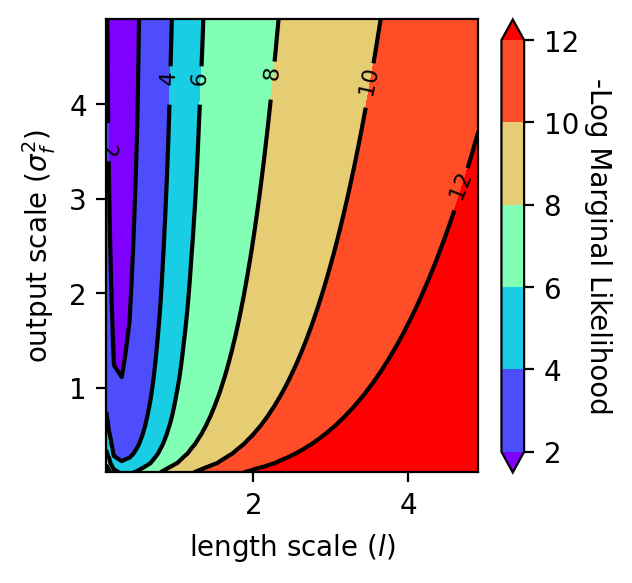

In [7]:
#@title ***(2.6) GPR Hyperparameters***

#@markdown With the noise hyperparameter $\sigma^2_n$, vertical variation 
#@markdown parameter $\sigma^2_f$, and the length scale $l$, we can say that for

#@markdown $\textbf{K}=\textbf{K}(\textbf{X},\textbf{X})+σ^2_n\textbf{I}$

#@markdown We can make a set of hyperparameters  $\Theta = \{σ^2_f, l, \sigma^2_n\}$ 
#@markdown that are optimized by maximizing the marginal likelihood log function: 

#@markdown $\mathrm{log}\:p(\textbf{y}|\textbf{X},\textbf{Θ})=-\frac{1}{2}\textbf{y}^\mathrm{T}\textbf{K}^{-1}\textbf{y}-\frac{1}{2}\mathrm{log}\:|\textbf{K}|-\frac{n}{2}\mathrm{log}\:2\pi$

#@markdown We will create a plot to demonstrate that the negative marginal 
#@markdown likelihood log function is smooth by fixing noise hyperparameter, 
#@markdown $\sigma^2_n$, and performing a grid search over the 
#@markdown lengthscale, $l$, and output/scale variance, $σ^2_f$


noise_value = 1.0
scale_and_length = [[i*.1,j*.1] for i in range(1,50) for j in range(1,50)]

x_plt = []
y_plt = []
z_plt = []

for pair in scale_and_length:
    hypers = {
        'likelihood.noise_covar.noise': torch.tensor(noise_value),
        'covar_module.base_kernel.lengthscale': torch.tensor(pair[0]),
        'covar_module.outputscale': torch.tensor(pair[1]),
    }
    model.initialize(**hypers)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    output = model(X_gpr)
    loss = -mll(output, Y_gpr)
    x_plt.append(pair[0])
    y_plt.append(pair[1])
    z_plt.append(loss.item())

fig = plt.figure(figsize=(3,3), dpi=200)

plt.subplot(1, 1, 1)
ct = plt.tricontour(x_plt, y_plt, z_plt, colors='k')
plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
ct = plt.tricontourf(x_plt, y_plt, z_plt, cmap=plt.cm.rainbow, extend='both')
#plt.title("- Marginal Likelihood Log") #moved colorbar CW
plt.xlabel("length scale ($l$)")
plt.ylabel("output scale ($σ^2_f$)")
plt.colorbar().set_label("-Log Marginal Likelihood",rotation=270, labelpad=12)

plt.show()

In [8]:
#@title ***(2.7) Training***
#@markdown Using the previously built class, we can now start to train the 
#@markdown model. 
#@markdown We will start with initial values for our hyperparameters and then 
#@markdown optimize the hyperparameters until the desired number of 
#@markdown iterations is reached. Then we will print the optimized hyperparameters.

model.train()
likelihood.train()

def train_model(model, likelihood, print_hp=False):
  hypers = {
      'likelihood.noise_covar.noise': torch.tensor(1.0),
      'covar_module.base_kernel.lengthscale': torch.tensor(1.0),
      'covar_module.outputscale': torch.tensor(1.0),
  }
  model.initialize(**hypers)
  if print_hp:
      # Print untrained hyperparameters
      for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param.item()}')

  training_iter = 100  #using 100 iterations
  # Find optimal model hyperparameters
  # Use the adam optimizer
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # Use the SGD optimizer with a learning rate of 0.1
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  

  # "Loss" for GPs = -(marginal log likelihood)
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  for i in range(training_iter):
    # Zero out the gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_gpr)    #in Lesson 1, we define the model output as "pred", which may be more clear to use here in order to distinguish from the output scale hyperparameter
    # Calculate loss and backpropagation gradients
    loss = -mll(output, Y_gpr)
    loss.backward() # updating the gradients
    if print_hp:
      print('Iter %d/%d - Loss: %.3f scale: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
      ))
      optimizer.step()
  if print_hp:
    # Print Trained hyperparameters
    for param_name, param in model.named_parameters():
      print(f'Parameter name: {param_name:42} value = {param.item()}')

train_model(model, likelihood, print_hp=True)

Parameter name: likelihood.noise_covar.raw_noise           value = 0.5411666631698608
Parameter name: covar_module.raw_outputscale               value = 0.5413248538970947
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.5413248538970947
Iter 1/100 - Loss: 5.879 scale: 1.000   lengthscale: 1.000   noise: 1.000
Iter 2/100 - Loss: 4.263 scale: 1.046   lengthscale: 0.787   noise: 1.136
Iter 3/100 - Loss: 3.360 scale: 1.087   lengthscale: 0.633   noise: 1.209
Iter 4/100 - Loss: 2.854 scale: 1.119   lengthscale: 0.536   noise: 1.250
Iter 5/100 - Loss: 2.479 scale: 1.149   lengthscale: 0.459   noise: 1.272
Iter 6/100 - Loss: 2.255 scale: 1.178   lengthscale: 0.405   noise: 1.279
Iter 7/100 - Loss: 2.135 scale: 1.204   lengthscale: 0.369   noise: 1.279
Iter 8/100 - Loss: 2.063 scale: 1.230   lengthscale: 0.345   noise: 1.275
Iter 9/100 - Loss: 2.014 scale: 1.254   lengthscale: 0.327   noise: 1.268
Iter 10/100 - Loss: 1.980 scale: 1.279   lengthscale: 0.313   noise: 1.260
I

Min/Max Differences, min: -1194.476291681258 max: 1.0934100702737446
Min/Max Variance, min: 0.03601408 max: 2.7670677


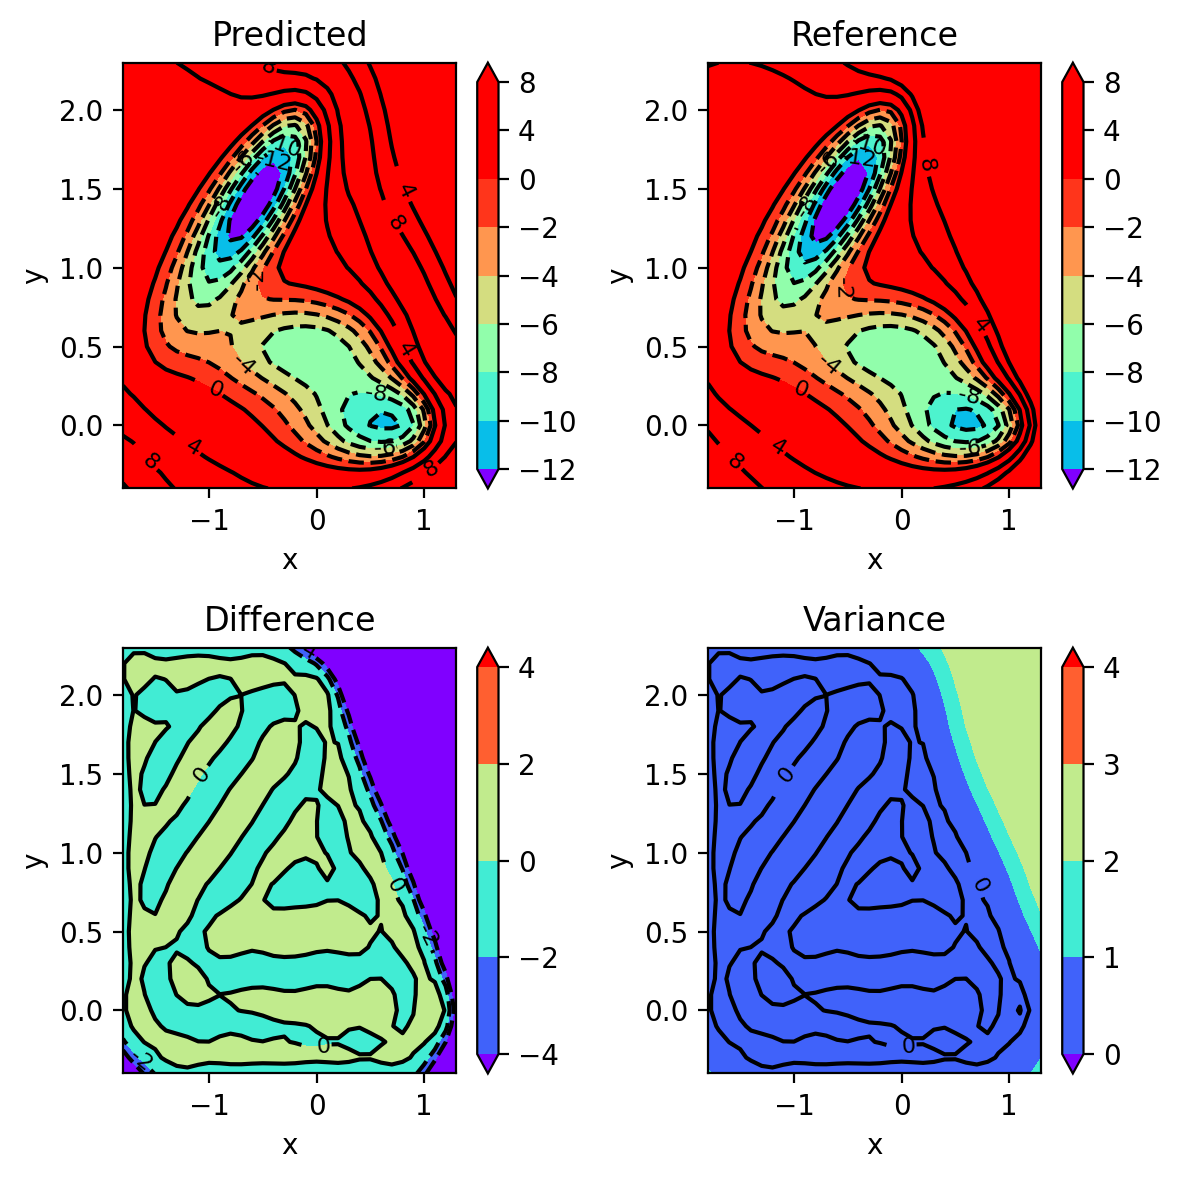

In [9]:
#@title ***(2.8) Plotting Predicted, Reference, Difference, and Variance Surfaces***

#@markdown The optimized model can be used to make predictions on new input 
#@markdown space, $\textbf{x}_*$. Predictions will follow a gaussian distribution

#@markdown $\mathcal{N}\sim(μ_*,\textbf{Σ}_*)$, where
#@markdown $μ^*=\textbf{K}^\mathrm{T}_\ast\textbf{K}^{-1}\textbf{y}$ and 
#@markdown $\textbf{Σ}_*=\textbf{K}_{**}-\textbf{K}^\mathrm{T}_*\textbf{K}^{-1}\textbf{K}_*$. 

#@markdown In the above equaiton, 

#@markdown $\textbf{K}_*=\textbf{K}(\textbf{X},\textbf{x}_*)$ 
#@markdown and $\textbf{K}_{**}=\textbf{K}(\textbf{x}_*,\textbf{x}_*)$

#@markdown We will use this to plot the GPR predicted surface (Predicted), the 
#@markdown analytical surface (Reference), the difference between the 
#@markdown predicted and analytical surfaces (Difference), and the variance of 
#@markdown the predicted points (Variance).

# Show the predicted surface, and compare to the reference one
def show_surface(model):
  model.eval()
  z_pred = model(Tensor(xy)).mean
  z_var = model(Tensor(xy)).variance
  Z_pred = np.reshape(z_pred.detach().numpy(),(len(yy),-1))
  Z_var = np.reshape(z_var.detach().numpy(),(len(yy),-1))
  Zdiff = np.subtract(Z_pred, Z)
  fig = plt.figure(figsize=(6,6), dpi=200)

  plt.subplot(2, 2, 1)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, Z_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Predicted")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(2, 2, 2)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, Z, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Reference")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(2, 2, 3)
  levels = [-4, -2, 0, 2, 4]
  ct = plt.contour(X, Y, Zdiff, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Zdiff, levels, cmap=plt.cm.rainbow, extend='both', vmin=-4, vmax=4)
  plt.title("Difference")
  plt.xlabel("x")
  plt.ylabel("y")
  print("Min/Max Differences, min:", np.amin(Zdiff),"max:", np.amax(Zdiff))
  plt.colorbar()

  plt.subplot(2, 2, 4)
  levels = [0, 1, 2, 3, 4]
  ct = plt.contour(X, Y, Zdiff, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_var, levels, cmap=plt.cm.rainbow, extend='both', vmin=0, vmax=4)
  plt.title("Variance")
  plt.xlabel("x")
  plt.ylabel("y")
  print("Min/Max Variance, min:", np.amin(Z_var),"max:", np.amax(Z_var))
  plt.colorbar()

  plt.tight_layout()

  plt.show()

show_surface(model)

In [11]:
#@title ***(2.9) Model Performance and Training Set Size***

#@markdown Now that our model works, we can look at how the size of our training 
#@markdown set changes the accuracy of our model. Below you can see that
#@markdown as the size of the training set increases, the root-mean square error (RMSE)
#@markdown decreases and the $R^2$ increases.

import tabulate

#print("Size of (current) training set:", Y_gpr.shape[0])
X_test = X_gpr.detach()
Y_test = Y_gpr.detach()
def evaluate_model(train_x, train_y, test_x, test_y, model):
  model.eval()
  preds_train = model(train_x).mean
  preds_test = model(test_x).mean
  #print(train_y.shape, preds_train.shape)
  rmse_train = torch.sqrt((torch.mean(train_y - preds_train)**2))   
  rmse_test = torch.sqrt((torch.mean(test_y - preds_test)**2))    
  r2 = 1 - torch.sum((train_y-preds_train)**2)/torch.sum((train_y-torch.mean(train_y))**2)
  q2 = 1 - torch.sum((train_y-preds_train)**2)/torch.sum((train_y-torch.mean(train_y))**2)
  #print("Training Data - RMSE: %.3f R^2: %3f" % (rmse_train, r2))
  #print("Teseting Data - RMSE: %.3f R^2: %3f" % (rmse_test, q2))
  return rmse_train, r2, rmse_test, q2

def reduce_training_set(train_x, train_y, new_size):
  arr_index = np.arange(train_y.shape[0])
  np.random.shuffle(arr_index)
  return train_x[arr_index[:new_size],:], train_y[arr_index[:new_size]]

def new_model(train_x, train_y):
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = ExactGPModel(train_x, train_y, likelihood)
  model.train()
  likelihood.train()
  train_model(model, likelihood, print_hp=False)
  return model

size_list = []
rmse_train_list = []
r2_list = []
rmse_test_list = []
q2_list = []

training_set_sizes = [696, 600, 500, 400, 300, 200, 100]
for set_size in training_set_sizes:
  X_gpr, Y_gpr = reduce_training_set(X_gpr, Y_gpr, set_size)
  model = new_model(X_gpr, Y_gpr)
  rmse_train, r2, rmse_test, q2 = evaluate_model(X_gpr, Y_gpr, X_test, Y_test, model)
  size_list.append(set_size)
  rmse_train_list.append(rmse_train)
  r2_list.append(r2)
  rmse_test_list.append(rmse_test)
  q2_list.append(q2)

training_set_dict = {
    'Training Set Size': size_list,
    'Training Set RMSE': rmse_train_list,
    'R^2': r2_list,
    'Testing Set RMSE': rmse_test_list,
    'Q^2': q2_list
}


print(tabulate.tabulate(training_set_dict, headers = 'keys'))

[tensor(0.1589, grad_fn=<SqrtBackward0>), tensor(0.1589, grad_fn=<SqrtBackward0>), tensor(0.1589, grad_fn=<SqrtBackward0>), tensor(0.1589, grad_fn=<SqrtBackward0>), tensor(0.1589, grad_fn=<SqrtBackward0>), tensor(0.1589, grad_fn=<SqrtBackward0>), tensor(0.1589, grad_fn=<SqrtBackward0>)]
  Training Set Size    Training Set RMSE       R^2    Testing Set RMSE       Q^2
-------------------  -------------------  --------  ------------------  --------
                696             0.158946  0.623086            0.158946  0.623086
                600             0.158947  0.623086            0.158946  0.623086
                500             0.158947  0.623086            0.158946  0.623086
                400             0.158948  0.623086            0.158948  0.623086
                300             0.158947  0.623086            0.158946  0.623086
                200             0.158948  0.623086            0.158947  0.623086
                100             0.158947  0.623086            0.

Comaparing Kernels

In [11]:
#@title Comparing Kernels

#@markdown Now we can compare GPR results using a different kernel. Before we used
#@markdown the RBF kernel, but now we can compare the performance of the RBF kernel
#@markdown with the Matern and Rational Quadratic (RQ) kernels. 

# Setup GPR Model: Taken directly From gpytorch tutorial with minor changes 
class GPModel_kernel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        #super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

X_gpr = Tensor(xy_truncated) 
Y_gpr = Tensor(z_truncated)

kernels = [
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel()),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())    
]

def train_model_k(model, likelihood):
  training_iter = 50
  # Use the SGD optimizer 
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_gpr)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_gpr)
    loss.backward()
    optimizer.step()

for kernel in kernels:
  # Initialize Likelihood and Model
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = GPModel_kernel(X_gpr, Y_gpr, likelihood, kernel)
  model.train()
  likelihood.train()
  train_model_k(model, likelihood)
  rmse_train, r2, rmse_test, q2 = evaluate_model(X_gpr, Y_gpr, X_test, Y_test, model)
  #Print the kernel we are running above the rmse_train output. CL
  print(rmse_train)





tensor(0.1140, grad_fn=<SqrtBackward0>)
tensor(0.1042, grad_fn=<SqrtBackward0>)
tensor(0.0918, grad_fn=<SqrtBackward0>)
